In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import seaborn as sns
import numpy as np
from IPython.display import Audio
import os

In [43]:
# Define path to speech and song directories
speech_dir = "Audio_Speech_Actors_01-24"
song_dir = "Audio_Song_Actors_01-24"

# Mapping from emotion number to label
emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

def extract_emotion_from_filename(filename):
    """Extracts emotion from RAVDESS filename."""
    parts = filename.split("-")
    emotion_code = parts[2]
    return emotion_map.get(emotion_code, "unknown")

def load_data(directory):
    """Loads RAVDESS wav files from a directory and returns a DataFrame with path and label."""
    data = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                full_path = os.path.join(root, file)
                label = extract_emotion_from_filename(file)
                data.append({"path": full_path, "labels": label})
    return pd.DataFrame(data)

# Load speech and song data
df_speech = load_data(speech_dir)
df_song = load_data(song_dir)

# Combine into one DataFrame
df_combined = pd.concat([df_speech, df_song], ignore_index=True)

# Shuffle (optional)
df_combined = df_combined.sample(frac=1).reset_index(drop=True)

# View sample
print(df_combined)

                                                   path   labels
0     Audio_Song_Actors_01-24\Actor_06\03-02-05-02-0...    angry
1     Audio_Song_Actors_01-24\Actor_12\03-02-02-02-0...     calm
2     Audio_Song_Actors_01-24\Actor_14\03-02-06-01-0...  fearful
3     Audio_Speech_Actors_01-24\Actor_14\03-01-04-02...      sad
4     Audio_Speech_Actors_01-24\Actor_08\03-01-04-02...      sad
...                                                 ...      ...
2447  Audio_Song_Actors_01-24\Actor_15\03-02-02-01-0...     calm
2448  Audio_Speech_Actors_01-24\Actor_02\03-01-02-02...     calm
2449  Audio_Song_Actors_01-24\Actor_21\03-02-03-01-0...    happy
2450  Audio_Speech_Actors_01-24\Actor_08\03-01-05-02...    angry
2451  Audio_Speech_Actors_01-24\Actor_17\03-01-05-01...    angry

[2452 rows x 2 columns]


In [44]:
df_combined = df_combined[df_combined['labels'] != 'sad']

In [45]:
df_combined['labels'].value_counts()

labels
angry        376
calm         376
fearful      376
happy        376
disgust      192
surprised    192
neutral      188
Name: count, dtype: int64

C:\Users\vy885\AppData\Local\Temp\ipykernel_26680\510770640.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


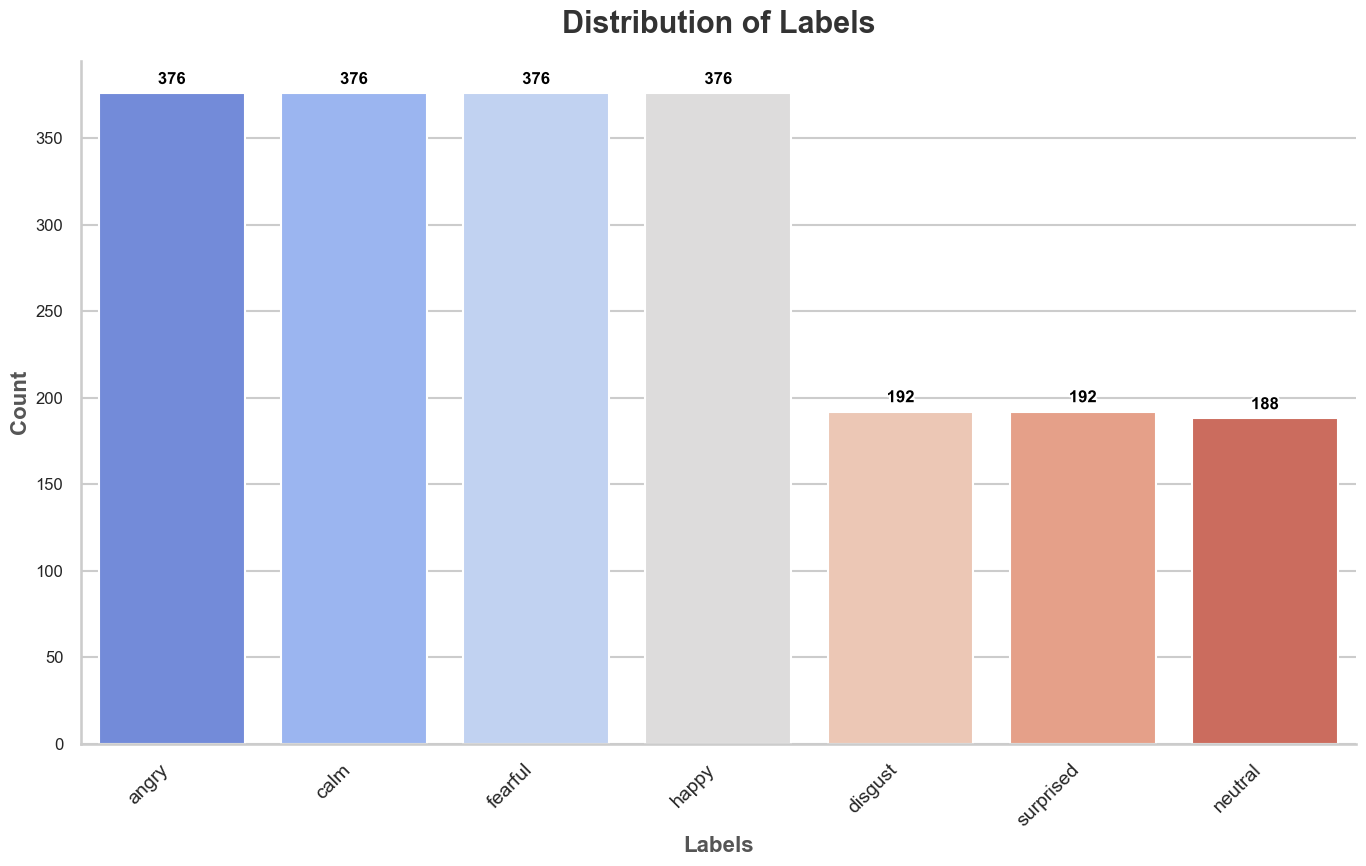

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects # <-- FIX: Add this import statement

# --- Assumes 'df_combined' DataFrame is already loaded ---

# Set a refined style and context
sns.set_style("whitegrid")
sns.set_context("talk")

# Create a larger figure
plt.figure(figsize=(14, 9))

# Create the countplot
ax = sns.countplot(
    x='labels',
    data=df_combined,
    palette='coolwarm',
    order=df_combined['labels'].value_counts().index
)

# Add data labels with a shadow/outline effect
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=12, 
                fontweight='bold',
                color='black',
                # <-- FIX: Use the imported 'path_effects' alias here
                path_effects=[
                    path_effects.withStroke(linewidth=3, foreground='white')
                ])

# Set title and labels
plt.title('Distribution of Labels', fontsize=22, fontweight='bold', color='#333333', pad=20)
plt.xlabel('Labels', fontsize=16, fontweight='bold', color='#555555')
plt.ylabel('Count', fontsize=16, fontweight='bold', color='#555555')

# Style the tick labels
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=12)

# Despine the plot
sns.despine()

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


In [48]:
import librosa
import numpy as np

def compute_log_mel_spect(y, sr, n_mels=128, hop_length=512, n_fft=2048, max_len=100):
    # Compute Mel spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                         hop_length=hop_length, n_fft=n_fft)
    
    # Convert to log scale
    log_mel = librosa.power_to_db(mel, ref=np.max)
    
    # Pad or trim to fixed length
    if log_mel.shape[1] < max_len:
        pad_width = max_len - log_mel.shape[1]
        log_mel = np.pad(log_mel, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        log_mel = log_mel[:, :max_len]

    # Normalize
    log_mel = (log_mel - np.mean(log_mel)) / (np.std(log_mel) + 1e-9)

    return log_mel


In [49]:
def plot_mel_spect(log_mel, sr):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_mel, sr=sr, hop_length=512, 
                                 x_axis='time', y_axis='mel', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-Mel Spectrogram')
    plt.tight_layout()
    plt.show()

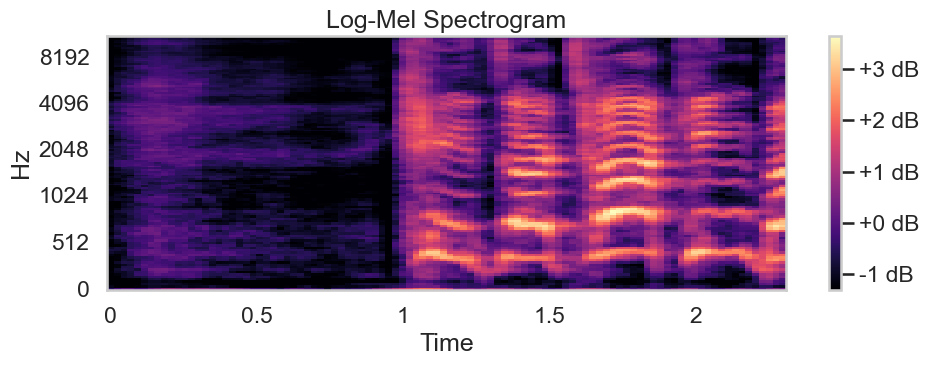

In [50]:
path = df_combined.iloc[0]['path']
data, sr = librosa.load(path)
log_mel = compute_log_mel_spect(data, sr)
plot_mel_spect(log_mel, sr)


In [51]:
features = []

for _, row in df_combined.iterrows():
    path = row['path']
    data, sr = librosa.load(path, sr=16000)
    log_spect = compute_log_mel_spect(data, sr)
    log_spect = np.expand_dims(log_spect, axis=-1)
    features.append(log_spect)

X = np.array(features)


In [52]:
X

array([[[[-0.60936636],
         [-0.23937055],
         [-0.13719973],
         ...,
         [-0.74210924],
         [-1.058636  ],
         [-0.82110214]],

        [[-1.2663949 ],
         [-1.4718416 ],
         [-1.4718416 ],
         ...,
         [-1.4718416 ],
         [-1.4718416 ],
         [-1.4718416 ]],

        [[-1.4718416 ],
         [-1.4718416 ],
         [-1.4718416 ],
         ...,
         [-1.4718416 ],
         [-1.4718416 ],
         [-1.4718416 ]],

        ...,

        [[-1.4718416 ],
         [-1.2505087 ],
         [-0.933686  ],
         ...,
         [-0.55470794],
         [-0.5151131 ],
         [-0.34295115]],

        [[-1.4718416 ],
         [-1.4567109 ],
         [-1.1468818 ],
         ...,
         [-0.38353032],
         [-0.6747753 ],
         [-0.3850087 ]],

        [[-1.4718416 ],
         [-1.4718416 ],
         [-1.4718416 ],
         ...,
         [-0.7660235 ],
         [-0.9931296 ],
         [-1.0723317 ]]],


       [[[-1.1056837 ],


In [53]:
X = np.squeeze(X)
X = np.expand_dims(X, -1)  # to ensure shape becomes (2452, 128, 100, 1)
print(X.shape)

(2076, 128, 100, 1)


In [54]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
y=enc.fit_transform(df_combined[['labels']])

In [55]:
y=y.toarray()

In [56]:
y.shape

(2076, 7)

In [57]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,GRU, Bidirectional
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [58]:
# 1. Encode string labels to integers
raw_y = df_combined['labels'].values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(raw_y)  # e.g., ['happy', 'sad'] → [1, 2]

# 2. Convert to one-hot for categorical_crossentropy loss
y_categorical = to_categorical(y_encoded)  # Shape: (samples, num_classes)

# 3. Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_categorical, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [59]:
from imblearn.over_sampling import RandomOverSampler
from keras.utils import to_categorical

# Flatten to 2D for oversampling: (samples, features)
# We’ll keep only time dimension: (samples, n_mels * time_steps)
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # shape: (num_samples, 128 * 100)

# Use RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled_flat, y_train_encoded_resampled = ros.fit_resample(X_train_flat, y_train_encoded)

# One-hot encode again for model training
y_train_resampled = to_categorical(y_train_encoded_resampled, num_classes=len(label_encoder.classes_))

# Reshape X_train back to original 4D shape: (samples, 128, 100, 1)
X_train_resampled = X_train_resampled_flat.reshape(-1, 128, 100, 1)


In [66]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import LSTM, Dense, Dropout, Reshape, Permute
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

def create_crnn_model(input_shape=(128, 100, 1), num_classes=8):
    model = Sequential()

    # ----- CNN Block -----
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))  # (64, 50, 32)

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))  # (32, 25, 64)

    # ----- Reshape for RNN -----
    model.add(Permute((2, 1, 3)))  # (time_steps, freq, channels)
    model.add(Reshape((25, 32 * 64)))  # (time_steps=25, features=2048)

    # ----- RNN Block -----
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(64))
    model.add(Dropout(0.3))

    # ----- Output -----
    model.add(Dense(num_classes, activation='softmax'))

    # ----- Compile -----
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# To make the training process better, use callbacks like EarlyStopping
early_stopping_callback = EarlyStopping(
    monitor='val_loss', # Monitor the validation loss
    patience=10,        # Stop after 10 epochs with no improvement
    verbose=1,
    restore_best_weights=True # Restore model weights from the best epoch
)

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)


c:\Users\vy885\OneDrive - iitr.ac.in\Desktop\openPro\speechEmotionClassification\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 128, 100, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 64, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 64, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 32, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_6 (Permute)             │ (None, 25, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 25, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 25, 128)        │     1,114,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,183,687 (4.52 MB)

 Trainable params: 1,183,495 (4.51 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.3181 - loss: 1.7815
Epoch 1: val_loss improved from inf to 1.92823, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 201ms/step - accuracy: 0.3191 - loss: 1.7799 - val_accuracy: 0.1827 - val_loss: 1.9282
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.5956 - loss: 1.3256
Epoch 2: val_loss improved from 1.92823 to 1.92426, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 206ms/step - accuracy: 0.5957 - loss: 1.3247 - val_accuracy: 0.1587 - val_loss: 1.9243
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.6604 - loss: 1.0712
Epoch 3: val_loss improved from 1.92426 to 1.88213, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 205ms/step - accuracy: 0.6608 - loss: 1.0704 - val_accuracy: 0.1659 - val_loss: 1.8821
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7740 - loss: 0.7869
Epoch 4: val_loss improved from 1.88213 to 1.74959, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 211ms/step - accuracy: 0.7741 - loss: 0.7866 - val_accuracy: 0.2692 - val_loss: 1.7496
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.8194 - loss: 0.6426
Epoch 5: val_loss improved from 1.74959 to 1.54460, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 222ms/step - accuracy: 0.8194 - loss: 0.6422 - val_accuracy: 0.3534 - val_loss: 1.5446
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.8509 - loss: 0.5463
Epoch 6: val_loss improved from 1.54460 to 1.27523, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 221ms/step - accuracy: 0.8511 - loss: 0.5456 - val_accuracy: 0.5144 - val_loss: 1.2752
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8995 - loss: 0.3916
Epoch 7: val_loss improved from 1.27523 to 1.12216, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - accuracy: 0.8995 - loss: 0.3914 - val_accuracy: 0.5938 - val_loss: 1.1222
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9170 - loss: 0.3255
Epoch 8: val_loss improved from 1.12216 to 0.83719, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 220ms/step - accuracy: 0.9172 - loss: 0.3251 - val_accuracy: 0.6923 - val_loss: 0.8372
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9470 - loss: 0.2372
Epoch 9: val_loss improved from 0.83719 to 0.62718, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - accuracy: 0.9470 - loss: 0.2371 - val_accuracy: 0.7933 - val_loss: 0.6272
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9608 - loss: 0.2126
Epoch 10: val_loss improved from 0.62718 to 0.48855, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - accuracy: 0.9608 - loss: 0.2124 - val_accuracy: 0.8293 - val_loss: 0.4886
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9755 - loss: 0.1431
Epoch 11: val_loss improved from 0.48855 to 0.43964, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 222ms/step - accuracy: 0.9755 - loss: 0.1431 - val_accuracy: 0.8654 - val_loss: 0.4396
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9856 - loss: 0.1111
Epoch 12: val_loss did not improve from 0.43964
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - accuracy: 0.9855 - loss: 0.1111 - val_accuracy: 0.8486 - val_loss: 0.4586
Epoch 13/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9900 - loss: 0.0769
Epoch 13: val_loss did not improve from 0.43964
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 211ms/step - accuracy: 0.9900 - loss: 0.0770 - val_accuracy: 0.8269 - val_loss: 0.5265
Epoch 14/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9885 - loss: 0.0778
Epoch 14: val_loss did not improve from 0.43964
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 212ms/step - accuracy: 0.9886 - loss: 0.0778 - val_accuracy: 0.8534 - val_loss: 0.4396
Epoch 15/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9945 - loss: 0.0505
Epoch 15: val_loss did not improve f

66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - accuracy: 0.9942 - loss: 0.0435 - val_accuracy: 0.8798 - val_loss: 0.4259
Epoch 17/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9994 - loss: 0.0321
Epoch 17: val_loss improved from 0.42587 to 0.39307, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 221ms/step - accuracy: 0.9994 - loss: 0.0321 - val_accuracy: 0.8630 - val_loss: 0.3931
Epoch 18/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9989 - loss: 0.0273
Epoch 18: val_loss improved from 0.39307 to 0.39190, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 221ms/step - accuracy: 0.9989 - loss: 0.0273 - val_accuracy: 0.8798 - val_loss: 0.3919
Epoch 19/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9986 - loss: 0.0249
Epoch 19: val_loss did not improve from 0.39190
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 224ms/step - accuracy: 0.9986 - loss: 0.0249 - val_accuracy: 0.8750 - val_loss: 0.4119
Epoch 20/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 1.0000 - loss: 0.0222
Epoch 20: val_loss did not improve from 0.39190
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 212ms/step - accuracy: 0.9999 - loss: 0.0222 - val_accuracy: 0.8486 - val_loss: 0.4565
Epoch 21/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9930 - loss: 0.0348
Epoch 21: val_loss did not improve from 0.39190
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 210ms/step - accuracy: 0.9930 - loss: 0.0351 - val_accuracy: 0.7668 - val_loss: 0.6947
Epoch 22/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9829 - loss: 0.0786
Epoch 22: val_loss did not improve f

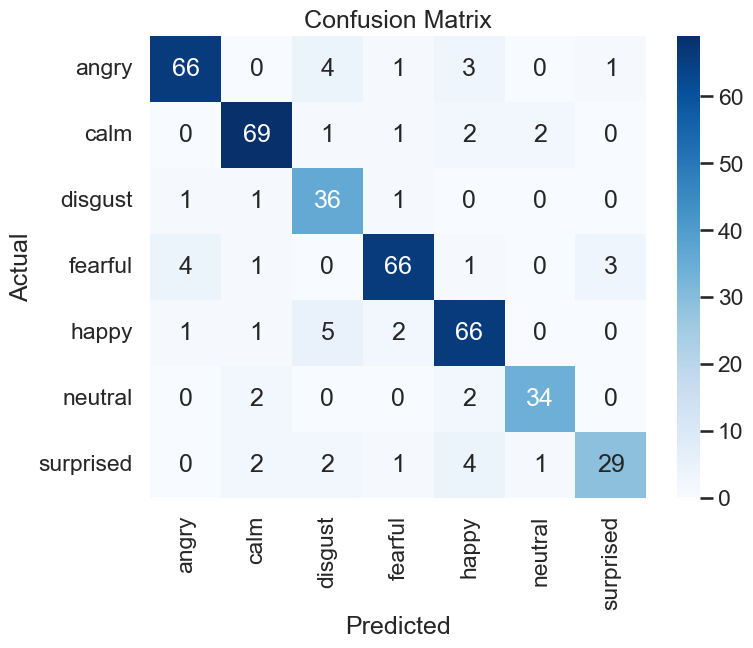

In [67]:
model = create_crnn_model(input_shape=(128, 100, 1), num_classes=y_train.shape[1])
model.summary()

history=model.fit(X_train_resampled, y_train_resampled,
          validation_data=(X_test, y_test),
          epochs=50, batch_size=32, callbacks=[early_stopping_callback, checkpoint])

# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save("crnn_model2.h5")  # HDF5 format

In [ ]:
from keras.models import load_model

model = load_model("crnn_model2.h5")


In [ ]:
import librosa
import numpy as np

# Load audio and extract log-Mel spectrogram
data, sr = librosa.load("test_audio.wav", sr=16000)
log_spec = compute_log_mel_spect(data, sr)  # Your function from before
log_spec = np.expand_dims(log_spec, axis=-1)  # (128, 100, 1)
log_spec = np.expand_dims(log_spec, axis=0)  # (1, 128, 100, 1)

# Predict
prediction = model.predict(log_spec)  # shape: (1, num_classes)
predicted_class = np.argmax(prediction)

# Decode class label
label = label_encoder.inverse_transform([predicted_class])[0]
print("Predicted Emotion:", label)
